# Traitement distribué de données massives
***
Ce document présente une approche efficace pour résoudre le problème de recherche des composants connectés dans un graphe donné. La résolution de ce problème peut être utile dans une grande variété de domaines d'application allant de l'analyse de communautés dans les réseaux sociaux, le regroupement basé sur la densité, la segmentation d'images, le couplage d'enregistrements, la tâche d'identification des enregistrements d'une base de données faisant référence à la même entité, etc.


Ce document est basé sur l'article [CCF: Fast and Scalable Connected Component Computation in MapReduce](https://www.cse.unr.edu/~hkardes/pdfs/ccf.pdf) écrit par H.Kardes, S.Agrawal, X.Wang et A.Sun en 2014.

In [1]:
import platform
import time
import warnings

import matplotlib.pyplot as plt
import pyspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession

warnings.filterwarnings('ignore')
root = "file://"
if "windows" in platform.system().lower():
    root = "file:////"

%matplotlib inline

conf = (pyspark.SparkConf(loadDefaults=False)
        .setAppName("connected-component")
        .setMaster("local[*]"))
ss = SparkSession.builder.config(conf=conf).getOrCreate()

D:\miniconda3\envs\data-study\lib\site-packages\pyspark\context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


## 1. Implémentation des algorithmes
***

De nombreux systèmes différents du monde réel peuvent être modélisés sous forme de graphes (nœuds/arêtes). Comme certains graphes ont une très grande taille, c'est un sujet d'actualité de construire des algorithmes parallélisés hautement évolutifs pour en extraire efficacement des informations utiles. Le framework Spark fournit des méthodes de calcul distribué qui permettent de traiter d'énormes volumes de données.

<img src="img/ccf.png" alt="CCF" width="800" style="width: 800px"/>

La figure ci-dessus résume le fonctionnement du module **Connected Component Finder (CCF)**.

- Les entrées sont une liste de toutes les arêtes du graphe. Nous rappelons que les arêtes sont modélisées par une paire (clé, valeur) représentant deux nœuds connectés.

- Les sorties sont les regroupements de chaque nœud du graphique au plus petit identifiant de nœud (nombre entier) du composant connexe auquel il appartient (choix arbitraire fait dans l'article pour identifier un composant).

Entre les entrées et les sorties, il y a une boucle sur 2 taches MapReduce jusqu'à ce que tous les nœuds soient affectés à leurs composants connexes :
1. CCF-Iterate : lier chaque nœud à l'identifiant de son composant connexe
2. CFF-Dedup : suppression des doublons générés par CCF-Iterate

Il existe 2 versions de CFF-Iterate. La deuxième version est destinée à améliorer la complexité temporelle en fournissant une collection triée à la tâche Reduce de CCF-Iterate. En effet, à un moment donné, l'algorithme a besoin de trouver la valeur minimale dans une liste. Au lieu de parcourir toute la liste, les valeurs peuvent être transmises au réducteur de manière triée avec un partitionnement personnalisé. Les auteurs précisent que cette amélioration ne fait pas une telle différence lorsque le graphe du graphe est relativement petit (<= 50k nœuds). Mais cela est plus efficace lorsqu'il s'agit de graphes avec des milliards de nœuds.

Le frameWork Spark nous donne la possibilité d'implémenter des algorithmes avec les classes RDD ou Dataframe représentant des collections distribuées.

### 1.1. Algorithmes avec Spark RDD
***

In [2]:
#Accumulateur distribué entre les taches MapReduce pour nous permettre de compter les paires générées par ccf_iterate
new_pairs_accumulator = ss.sparkContext.accumulator(0)


#Algoritme Reduce du CCF-Iterate générant un itérateur de paire (clé, valeur)
def ccf_iterate_reduce(pair):
    key, values = pair
    minimum = key
    value_list = []
    for value in values:
        if value < minimum:
            minimum = value
        value_list.append(value)
    if minimum < key:
        yield key, minimum
        for value in value_list:
            if minimum != value:
                new_pairs_accumulator.add(1)
                yield value, minimum


#Algoritme Reduce du CCF-Iterate avec tri secondaire générant un itérateur de paire (clé, valeur)
def ccf_iterate_reduce_with_secondary_sorting(pair):
    key, values = pair
    minimum = values[0]
    if minimum < key:
        yield key, minimum
        i = 0
        for value in values:
            if i != 0:
                new_pairs_accumulator.add(1)
                yield value, minimum
            i += 1


#Algorithme permettant de trier les résultats du Map de CCF-Iterate
def sort_group_values(pair):
    key, values = pair
    return key, sorted(values)


#Algoritme d'une itération de CCF-Iterate incluant Map et Reduce
def ccf_iterate(rdd):
    map_job = rdd.flatMap(lambda x: [(x[0], x[1]), (x[1], x[0])]).groupByKey()
    reduce_job = map_job.flatMap(lambda pair: ccf_iterate_reduce(pair))
    return map_job, reduce_job


#Algoritme d'une itération de CCF-Iterate avec tri secondaire incluant Map et Reduce
def ccf_iterate_with_secondary_sorting(rdd):
    map_job = rdd.flatMap(lambda x: [(x[0], x[1]), (x[1], x[0])]).groupByKey().map(lambda pair: sort_group_values(pair))
    reduce_job = map_job.flatMap(lambda pair: ccf_iterate_reduce_with_secondary_sorting(pair))
    return map_job, reduce_job


#Algoritme permettant de supprimer les doublons après une Phase Reduce de CCF-Iterate
def ccf_dedup(rdd):
    return rdd.distinct()


#Algoritme permettant d'exécuter toutes les itérations possibles de CCF-Iterate avec tri secondaire ou non
def process_ccf_iterate(rdd, sorting=False):
    i = 0
    edges = rdd
    new_pairs_accumulator.value = 1
    while new_pairs_accumulator.value > 0:
        i += 1
        new_pairs_accumulator.value = 0
        if sorting:
            map_job, reduce_job = ccf_iterate_with_secondary_sorting(edges)
            edges = ccf_dedup(reduce_job)
        else:
            map_job, reduce_job = ccf_iterate(edges)
            edges = ccf_dedup(reduce_job)
        edge_count = edges.count()
        print("=======> (Iteration : " + str(i) + "), (New Pairs : " + str(new_pairs_accumulator.value) +
              "), (Edge count : " + str(edge_count) + ")")
        if new_pairs_accumulator.value == 0:
            return map_job


def print_distinct_connected_components(rdd):
    keys = rdd.keys().collect()
    cc = rdd.filter(lambda y: not ((len(y[1]) == 1) and (list(y[1])[0] in keys)))
    for row in cc.collect():
        print("(" + str(row[0]) + ", [", end='')
        i = 0
        for val in row[1]:
            if i > 0:
                print(", ", end='')
            print(str(val), end='')
            i += 1
        print("])")


def print_largest_components_size(rdd):
    size = rdd.map(lambda x: len(x[1])).max() + 1
    print("The largest component has " + str(size) + " elements")

### 1.2. Algorithmes avec Spark DataFrame
***

In [3]:
from pyspark.sql.functions import array, collect_list, explode, udf, sort_array
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, IntegerType


#Algoritme Reduce du CCF-Iterate générant le nombre de nouvelles paires générées et une liste de paire (clé, valeur)
#L'accumulateur utilisé dans les implementations RDD ne marche pas avec les Udf Dataframe après des tests.
#D'après les tests, une fois l'accumulateur modifié par une Udf de Dataframe dans une itération, il devient non_modifiable ou non-réinitialisable par le processus pilote
@udf(returnType=StructType(
    [StructField("new_pairs", IntegerType()), StructField("edges", ArrayType(ArrayType(StringType())))]))
def ccf_iterate_reduce_udf(key, values):
    new_pairs_counter = 0
    minimum = key
    value_list = []
    result = []
    for value in values:
        if value < minimum:
            minimum = value
        value_list.append(value)
    if minimum < key:
        result.append([key, minimum])
        for value in value_list:
            if minimum != value:
                new_pairs_counter += 1
                result.append([value, minimum])
    return new_pairs_counter, result


#Algoritme Reduce du CCF-Iterate avec tri secondaire générant le nombre de nouvelles paires générées et une liste de paire (clé, valeur)
@udf(returnType=StructType(
    [StructField("new_pairs", IntegerType()), StructField("edges", ArrayType(ArrayType(StringType())))]))
def ccf_iterate_reduce_with_secondary_sorting_udf(key, values):
    new_pairs_counter = 0
    minimum = values[0]
    result = []
    if minimum < key:
        result.append([key, minimum])
        i = 0
        for value in values:
            if i != 0:
                new_pairs_counter += 1
                result.append([value, minimum])
            i += 1
    return new_pairs_counter, result


#Algoritme d'une itération de CCF-Iterate avec tri secondaire ou non incluant Map et Reduce
def ccf_iterate_df(dataframe, sorting=False):
    df_map_job = dataframe \
        .transform(
        lambda df: df.select(explode(array(array(df.columns[0], df.columns[1]), array(df.columns[1], df.columns[0]))))) \
        .transform(lambda df: df.select(df[0].getItem(0), df[0].getItem(1))) \
        .transform(lambda df: df.groupBy(df.columns[0]).agg(collect_list(df.columns[1])))
    if sorting:
        df_map_job = df_map_job.select(df_map_job.columns[0], sort_array(df_map_job.columns[1]))
        df_reduce_job = df_map_job.transform(
            lambda df: df.select(ccf_iterate_reduce_with_secondary_sorting_udf(df[0], df[1])))
        return df_map_job, df_reduce_job
    else:
        df_reduce_job = df_map_job.transform(lambda df: df.select(ccf_iterate_reduce_udf(df[0], df[1])))
        return df_map_job, df_reduce_job


#Algoritme permettant de supprimer les doublons après une Phase Reduce de CCF-Iterate
def ccf_dedup_df(dataframe):
    return dataframe.distinct()


#Algoritme permettant d'exécuter toutes les itérations possibles de CCF-Iterate avec tri secondaire ou non
def process_ccf_iterate_df(dataframe, sorting=False):
    i = 0
    edges = dataframe
    new_pairs_were_produced = True
    while new_pairs_were_produced:
        i += 1
        map_job, reduce_job = ccf_iterate_df(edges, sorting=sorting)

        reduce_job_edges = reduce_job.transform(lambda df: df.select(explode(df[0].getField("edges")))) \
            .transform(lambda df: df.select(df[0].getItem(0), df[0].getItem(1)))
        df_reduce_job_new_pairs_counter = reduce_job.transform(lambda df: df.select(df[0].getField("new_pairs"))) \
            .transform(lambda df: df.filter("`" + df.columns[0] + "`> 0"))
        new_pairs_were_produced = df_reduce_job_new_pairs_counter.count() > 0

        edges = ccf_dedup_df(reduce_job_edges)
        edge_count = edges.count()
        print("=======> (Iteration : " + str(i) + "), (New Pairs were produced : " +
              str(new_pairs_were_produced) + "), (Edge count : " + str(edge_count) + ")")
        if not new_pairs_were_produced:
            return map_job

## 2. Analyse expérimentale des algorithmes sur des graphes de grandes tailles
***

Les auteurs revendiquent la viabilité de leur approche sur un graphe massif d'environ 6 milliards de nœuds. Dans ce document, nous avons utilisé ordinateur portable pour tester nos implémentations sur des graphes plus petits compte tenu du cout élevé des ressources de calcul.

Nous avons choisi d'utiliser des graphes sur internet dont le [Berkeley-Stanford web graph](https://snap.stanford.edu/data/web-BerkStan.html) d'environ 685 milles nœuds et 7.6 millions d'arêtes, puis le [Web Google graph](http://snap.stanford.edu/data/web-Google.html) d'environ 875 milles nœuds et 5,1 millions d'arêtes. Les nœuds représentent des pages Web et les segments orientés représentent des hyperliens entre eux. Les données contiennent 2 colonnes. Chaque ligne (hormis les en-têtes) est un couple (clé, valeur) qui représente 2 nœuds connectés.

### 2.1. Graphe 1
***

In [4]:
ss.sparkContext.addFile("https://gitlab.com/diehl17/data/-/raw/main/web/web-BerkStan.txt")
raw_data = ss.sparkContext.textFile(root + SparkFiles.get("web-BerkStan.txt"))

raw_data = raw_data.filter(lambda x: "#" not in x)
rdd_graph = raw_data.map(lambda x: x.split("\t"))
df_graph = rdd_graph.toDF()
df_graph.show()

+------+------+
|    _1|    _2|
+------+------+
|     1|     2|
|     1|     5|
|     1|     7|
|     1|     8|
|     1|     9|
|     1|    11|
|     1|    17|
|     1|254913|
|     1|438238|
|254913|255378|
|254913|255379|
|254913|255383|
|254913|255384|
|254913|255392|
|254913|255393|
|254913|255394|
|254913|255396|
|254913|255399|
|254913|255401|
|254913|255402|
+------+------+


#### a. CCF-iterate avec Spark RDD
***

In [5]:
print("******** Start ********")
start_time = time.time()
components = process_ccf_iterate(rdd_graph)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components)

******** Start ********
=======> (Iteration : 1), (New Pairs : 13994745), (Edge count : 2535600)
=======> (Iteration : 2), (New Pairs : 4186243), (Edge count : 1837453)
=======> (Iteration : 3), (New Pairs : 2696208), (Edge count : 1362051)
=======> (Iteration : 4), (New Pairs : 1471388), (Edge count : 902766)
=======> (Iteration : 5), (New Pairs : 455636), (Edge count : 778913)
=======> (Iteration : 6), (New Pairs : 199724), (Edge count : 779988)
=======> (Iteration : 7), (New Pairs : 200543), (Edge count : 791136)
=======> (Iteration : 8), (New Pairs : 220839), (Edge count : 786668)
=======> (Iteration : 9), (New Pairs : 209516), (Edge count : 759304)
=======> (Iteration : 10), (New Pairs : 151397), (Edge count : 691340)
=======> (Iteration : 11), (New Pairs : 13740), (Edge count : 684749)
=======> (Iteration : 12), (New Pairs : 390), (Edge count : 684554)
=======> (Iteration : 13), (New Pairs : 0), (Edge count : 684554)
******** End ********

Total elapsed time : 208.59819912910461 

#### b. CCF-iterate avec Spark RDD et tri secondaire
***

In [6]:
print("******** Start ********")
start_time = time.time()
components = process_ccf_iterate(rdd_graph, sorting=True)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components)

******** Start ********
=======> (Iteration : 1), (New Pairs : 14100356), (Edge count : 2591960)
=======> (Iteration : 2), (New Pairs : 4291433), (Edge count : 1837453)
=======> (Iteration : 3), (New Pairs : 2696208), (Edge count : 1362051)
=======> (Iteration : 4), (New Pairs : 1471388), (Edge count : 902766)
=======> (Iteration : 5), (New Pairs : 455636), (Edge count : 778913)
=======> (Iteration : 6), (New Pairs : 199724), (Edge count : 779988)
=======> (Iteration : 7), (New Pairs : 200543), (Edge count : 791136)
=======> (Iteration : 8), (New Pairs : 220839), (Edge count : 786668)
=======> (Iteration : 9), (New Pairs : 209516), (Edge count : 759304)
=======> (Iteration : 10), (New Pairs : 151397), (Edge count : 691340)
=======> (Iteration : 11), (New Pairs : 13740), (Edge count : 684749)
=======> (Iteration : 12), (New Pairs : 390), (Edge count : 684554)
=======> (Iteration : 13), (New Pairs : 0), (Edge count : 684554)
******** End ********

Total elapsed time : 224.2116150856018 s

#### c. CCF-iterate avec Spark Dataframe
***

In [7]:
print("******** Start ********")
start_time = time.time()
components_df = process_ccf_iterate_df(df_graph)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components_df.rdd)

******** Start ********
=======> (Iteration : 1), (New Pairs were produced : True), (Edge count : 2535600)
=======> (Iteration : 2), (New Pairs were produced : True), (Edge count : 1837453)
=======> (Iteration : 3), (New Pairs were produced : True), (Edge count : 1362051)
=======> (Iteration : 4), (New Pairs were produced : True), (Edge count : 902766)
=======> (Iteration : 5), (New Pairs were produced : True), (Edge count : 778913)
=======> (Iteration : 6), (New Pairs were produced : True), (Edge count : 779988)
=======> (Iteration : 7), (New Pairs were produced : True), (Edge count : 791136)
=======> (Iteration : 8), (New Pairs were produced : True), (Edge count : 786668)
=======> (Iteration : 9), (New Pairs were produced : True), (Edge count : 759304)
=======> (Iteration : 10), (New Pairs were produced : True), (Edge count : 691340)
=======> (Iteration : 11), (New Pairs were produced : True), (Edge count : 684749)
=======> (Iteration : 12), (New Pairs were produced : True), (Edge co

#### d. CCF-iterate avec Spark Dataframe et tri secondaire
***

In [8]:
print("******** Start ********")
start_time = time.time()
components_df = process_ccf_iterate_df(df_graph, sorting=True)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components_df.rdd)

******** Start ********
=======> (Iteration : 1), (New Pairs were produced : True), (Edge count : 2591960)
=======> (Iteration : 2), (New Pairs were produced : True), (Edge count : 1837453)
=======> (Iteration : 3), (New Pairs were produced : True), (Edge count : 1362051)
=======> (Iteration : 4), (New Pairs were produced : True), (Edge count : 902766)
=======> (Iteration : 5), (New Pairs were produced : True), (Edge count : 778913)
=======> (Iteration : 6), (New Pairs were produced : True), (Edge count : 779988)
=======> (Iteration : 7), (New Pairs were produced : True), (Edge count : 791136)
=======> (Iteration : 8), (New Pairs were produced : True), (Edge count : 786668)
=======> (Iteration : 9), (New Pairs were produced : True), (Edge count : 759304)
=======> (Iteration : 10), (New Pairs were produced : True), (Edge count : 691340)
=======> (Iteration : 11), (New Pairs were produced : True), (Edge count : 684749)
=======> (Iteration : 12), (New Pairs were produced : True), (Edge co

#### e. Variation de la taille des composants connectés
***

In [9]:
cc = components.map(lambda x: (len(x[1]), 1)).filter(lambda x: x[0] > 1)
cc = cc.reduceByKey(lambda x, y: x + y)
X = cc.map(lambda x: x[0]).collect()  #key = Different sizes of connected components
Y = cc.map(lambda x: x[1]).collect()  #value = The total number of connected components having a certain size

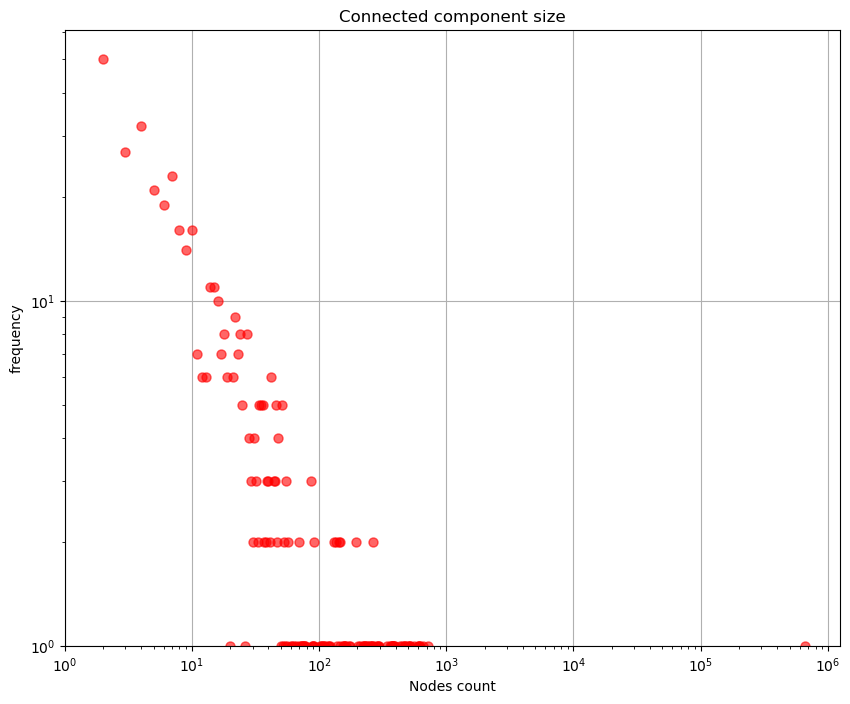

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(X, Y, 'rx', marker='.', markersize=13, alpha=0.6, color='r')

plt.xscale("log")
plt.xlabel("Nodes count")
plt.xlim(left=1)

plt.yscale("log")
plt.ylabel("frequency")
plt.ylim(bottom=1)

plt.title("Connected component size")
plt.grid(True)

### 2.1. Graphe 2
***

In [6]:
ss.sparkContext.addFile("https://gitlab.com/diehl17/data/-/raw/main/web/web-Google.txt")
raw_data = ss.sparkContext.textFile(root + SparkFiles.get("web-Google.txt"))

raw_data = raw_data.filter(lambda x: "#" not in x)
rdd_graph = raw_data.map(lambda x: x.split("\t"))
df_graph = rdd_graph.toDF()

df_graph.show()

+------+------+
|    _1|    _2|
+------+------+
|     0| 11342|
|     0|824020|
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
+------+------+


#### a. CCF-iterate avec Spark RDD
***

In [13]:
print("******** Start ********")
start_time = time.time()
components = process_ccf_iterate(rdd_graph)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components)

******** Start ********
=======> (Iteration : 1), (New Pairs : 8546673), (Edge count : 3237785)
=======> (Iteration : 2), (New Pairs : 4774134), (Edge count : 2112394)
=======> (Iteration : 3), (New Pairs : 3235857), (Edge count : 2408734)
=======> (Iteration : 4), (New Pairs : 3852842), (Edge count : 1859063)
=======> (Iteration : 5), (New Pairs : 2014247), (Edge count : 919907)
=======> (Iteration : 6), (New Pairs : 94614), (Edge count : 873741)
=======> (Iteration : 7), (New Pairs : 1548), (Edge count : 872967)
=======> (Iteration : 8), (New Pairs : 0), (Edge count : 872967)
******** End ********

Total elapsed time : 231.62047219276428 secondes
The largest component has 855802 elements


#### b. CCF-iterate avec Spark RDD et tri secondaire
***

In [10]:
print("******** Start ********")
start_time = time.time()
components = process_ccf_iterate(rdd_graph, sorting=True)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components)

******** Start ********
=======> (Iteration : 1), (New Pairs : 8666408), (Edge count : 3277439)
=======> (Iteration : 2), (New Pairs : 4837940), (Edge count : 2112394)
=======> (Iteration : 3), (New Pairs : 3235857), (Edge count : 2408734)
=======> (Iteration : 4), (New Pairs : 3852842), (Edge count : 1859063)
=======> (Iteration : 5), (New Pairs : 2014247), (Edge count : 919907)
=======> (Iteration : 6), (New Pairs : 94614), (Edge count : 873741)
=======> (Iteration : 7), (New Pairs : 1548), (Edge count : 872967)
=======> (Iteration : 8), (New Pairs : 0), (Edge count : 872967)
******** End ********

Total elapsed time : 238.28759622573853 secondes
The largest component has 855802 elements


#### c. CCF-iterate avec Spark Dataframe
***

In [7]:
print("******** Start ********")
start_time = time.time()
components_df = process_ccf_iterate_df(df_graph)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components_df.rdd)

******** Start ********
=======> (Iteration : 1), (New Pairs were produced : True), (Edge count : 3237785)
=======> (Iteration : 2), (New Pairs were produced : True), (Edge count : 2112394)
=======> (Iteration : 3), (New Pairs were produced : True), (Edge count : 2408734)
=======> (Iteration : 4), (New Pairs were produced : True), (Edge count : 1859063)
=======> (Iteration : 5), (New Pairs were produced : True), (Edge count : 919907)
=======> (Iteration : 6), (New Pairs were produced : True), (Edge count : 873741)
=======> (Iteration : 7), (New Pairs were produced : True), (Edge count : 872967)
=======> (Iteration : 8), (New Pairs were produced : False), (Edge count : 872967)
******** End ********

Total elapsed time : 1747.2666165828705 secondes
The largest component has 855802 elements


#### d. CCF-iterate avec Spark Dataframe et tri secondaire
***

In [8]:
print("******** Start ********")
start_time = time.time()
components_df = process_ccf_iterate_df(df_graph, sorting=True)
time_ccf = time.time() - start_time
print("******** End ********")
print("\nTotal elapsed time :", time_ccf, "secondes")
print_largest_components_size(components_df.rdd)

******** Start ********
=======> (Iteration : 1), (New Pairs were produced : True), (Edge count : 3277439)
=======> (Iteration : 2), (New Pairs were produced : True), (Edge count : 2112394)
=======> (Iteration : 3), (New Pairs were produced : True), (Edge count : 2408734)
=======> (Iteration : 4), (New Pairs were produced : True), (Edge count : 1859063)
=======> (Iteration : 5), (New Pairs were produced : True), (Edge count : 919907)
=======> (Iteration : 6), (New Pairs were produced : True), (Edge count : 873741)
=======> (Iteration : 7), (New Pairs were produced : True), (Edge count : 872967)
=======> (Iteration : 8), (New Pairs were produced : False), (Edge count : 872967)
******** End ********

Total elapsed time : 1790.7637417316437 secondes
The largest component has 855802 elements


#### e. Variation de la taille des composants connectés
***

In [11]:
cc = components.map(lambda x: (len(x[1]), 1)).filter(lambda x: x[0] > 1)
cc = cc.reduceByKey(lambda x, y: x + y)
X = cc.map(lambda x: x[0]).collect()  #key = Different sizes of connected components
Y = cc.map(lambda x: x[1]).collect()  #value = The total number of connected components having a certain size

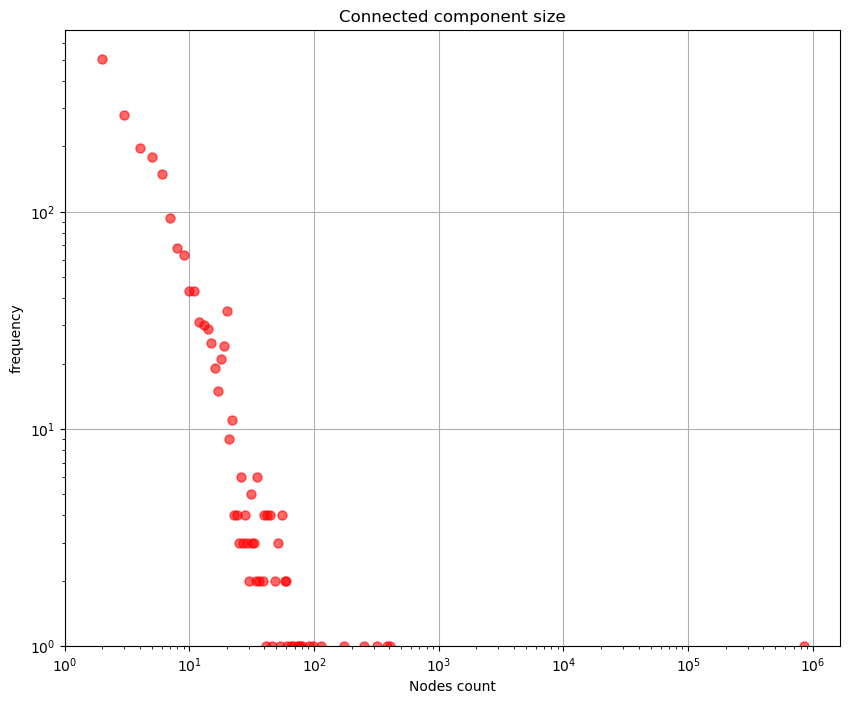

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(X, Y, 'rx', marker='.', markersize=13, alpha=0.6, color='r')

plt.xscale("log")
plt.xlabel("Nodes count")
plt.xlim(left=1)

plt.yscale("log")
plt.ylabel("frequency")
plt.ylim(bottom=1)

plt.title("Connected component size")
plt.grid(True)

***
Arrivé au terme de notre article, nous avons pu utiliser deux ensembles de données réels dans nos expériences et nous avons pu comparer une implémentation avec Spark RDD par rapport à une autre avec Spark Dataframe. Nous constatons que notre approche avec Spark RDD a obtenu les meilleures performances en termes de temps d'exécution total et a été moins complexe à mettre en place. La raison principale de ce résultat est que Spark SQL et sa classe Dataframe ne fournit pas des méthodes adaptées à l'analyse des graphes, mais plutôt adaptés à l'analyse des données relationnelles. Cette inadéquation de Spark SQL nous a alors obligé à surcharger des opérations couteuses pour reproduire le comportement des opérations MapReduce utilisable avec RDD.